# Content 
- [Import Data](#Import-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Preprocessing](#Data-Preprocessing)
- [Tokenization](#Tokenization)
- [Naive Bayes Classifier](#Naive-Bayes-Classifier)
- [Tuning Parameter by CV](#Tuning-Parameter-by-CV)
- [Model Evaluation](#Model-Evaluation)
- [Final Model](#Final-Model)
- [Prediction](#Prediction)
- [Further Work](#Further-Work)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import string
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

from scipy.stats import chi2_contingency

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
import sys

sys.path.append('../../')

from utils import plot_roc, plot_ks, confusion_matrix, EmpiricalBootstrappingROC

# Import Data

In [3]:
data = pd.read_csv('../../data/Disaster/train.csv', index_col = 0)
data.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(f'The shape of the dataset is {data.shape}')

The shape of the dataset is (7613, 4)


<li><code>keyword</code>: a particular keyword from the tweet (may be blank)</li>
<li><code>location</code>: the location the tweet was sent from (may be blank)</li>
<li><code>text</code>: the text of the tweet</li>
<li><code>target</code>: denotes whether a tweet is about a real disaster (1) or not (0)</li>

# Exploratory Data Analysis

In [5]:
samples = data.dropna(subset = ['keyword']).sample(5)
for index in samples.index:
    for col in data.columns:
        print(f'{col}:', samples.loc[index, col])
    print()

keyword: suicide%20bombing
location: Memphis
text: Kurd Suicide Attack Kills 2 Turkish Soldiers http://t.co/GHGHQm9e6d
target: 1

keyword: flattened
location: Mississauga, Ontario
text: @tweetingLew @tersestuff 

Notley flattened Harper IN HIS Heartland
Harper Imported tens of thousands of TFW slaves COST ALBERTANS JOBS
target: 0

keyword: annihilated
location: nan
text: @Volfan326 @TNeazzy Mizzou has annihilated florida the past 2 seasons even ended muschamp's career just can't compete with Bama
target: 0

keyword: emergency
location: nan
text: Emergency root canal!! #tookitlikeaman #lovemydentist #sore
target: 0

keyword: refugees
location: Bangalore, India
text: #Turkish couple decided to feed 4000 #Syrian #refugees as part of their #wedding celebrations http://t.co/EHLq3ZSPTd http://t.co/DjX5eLbrv1
target: 0



Observations:
- Keyword and location are probably extracted by some unknown algorithm. These two may not be found in the tweet
    - In reality, when predicting for a new tweet, these two attributes are porbably not provided.
- Tweet with url are more probably about disaster.
    - Twitter uses its own t.co domain to shorten links in your tweets, but it's done after you post so that you don't get to use the full 140 characters. Visit one of the other shortening sites for ways to shorten URLs in advance.
    - https://www.dummies.com/article/technology/social-media/twitter/how-to-insert-links-into-tweets-187355/
- %20 is used in url as a valid input representing white space.

In [6]:
data['keyword2'] = data['keyword']
data.loc[~data['keyword2'].isna(), 'keyword2'] = data.loc[~data['keyword2'].isna(), 'keyword2'].apply(lambda x: x.replace('%20', ' '))

In [7]:
data['keyword2'].value_counts(dropna = False)

NaN                    61
fatalities             45
deluge                 42
armageddon             42
sinking                41
                       ..
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: keyword2, Length: 222, dtype: int64

In [8]:
data['keyword2'].unique()
# need lemmatization

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desol

In [9]:
data[data['target'] == 1]['keyword2'].value_counts().head(10)

derailment         39
wreckage           39
outbreak           39
debris             37
oil spill          37
typhoon            37
evacuated          32
suicide bombing    32
rescuers           32
suicide bomb       32
Name: keyword2, dtype: int64

In [10]:
data[data['target'] == 0]['keyword2'].value_counts().head(10)
# In general, tweets have different set of keyword when they are related to disaster
# However, ome of the keywords like wreckage are not useful in predicting the diasaster, as they frequently occur in tweets 
# either about diasater or not related to diasater.

body bags     40
harm          37
armageddon    37
wrecked       36
ruin          36
deluge        36
explode       35
twister       35
fear          35
siren         35
Name: keyword2, dtype: int64

In [11]:
data['location'].value_counts(dropna = False)
# Most are without location

NaN                             2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

In [12]:
data[data['target'] == 1]['location'].value_counts().head(20)

USA                 67
United States       27
Nigeria             22
India               20
Mumbai              19
UK                  16
London              16
New York            16
Washington, DC      15
Canada              13
Worldwide           12
Washington, D.C.     9
Chicago, IL          9
Australia            9
Indonesia            8
Los Angeles, CA      8
California, USA      8
Earth                8
California           7
New York, NY         7
Name: location, dtype: int64

In [13]:
data[data['target'] == 0]['location'].value_counts().head(20)

New York           55
USA                37
London             29
United States      23
Los Angeles, CA    18
Canada             16
Kenya              15
Everywhere         12
Florida            11
UK                 11
California         10
NYC                10
United Kingdom     10
ss                  9
London, England     9
Australia           9
Chicago, IL         9
304                 9
San Francisco       8
New York, NY        8
Name: location, dtype: int64

In [14]:
data['location'].dropna().sample(20)
# many noises and not useful in prediction

id
5442            Los Angeles, CA
5565                   New York
7643                 California
2777    A.A.S my Aztec Princess
4860     Moncton, New Brunswick
5650          Global-NoLocation
5249                         TX
129                    Maldives
2808                        USA
1817              New Hampshire
3690                     Norway
1677        Buscame EL tu Melte
7006                 Boston, MA
3642               Richmond, VA
3142                  Hong Kong
4596                Augusta, GA
2993               Planet Earth
353             Subconscious LA
6466                        USA
864                 Atlanta, GA
Name: location, dtype: object

In [15]:
print(data.loc[data['target'] == 1, 'text'].sample(10).values)
# hashtag
# html tag
# @ tag
# \r\n
# url

['FedEx no longer will ship potential bioterror pathogens - FedEx Corp. (NYSE: FDX) will no longer deliver packages ... http://t.co/2kdq56xTWs'
 'Dudes will thoroughly express how stupid black ppl r for burning buildings in response to brutality but nvr mention them being mistreated.'
 'Check out my Lava lamp dude ???? http://t.co/To9ViqooFv'
 'SoloQuiero Maryland mansion fire that killed 6 caused by damaged plug under Christmas tree report says - Into the flames: Firefighte...'
 'The media needs to stop publicizing mass murder. So many sick people do these things for the eyes of the world &amp; the media is not helping.'
 '@msnbc What a fucking idiot. He had a gun &amp; a hatchet yet there were still no serious injuries. Glad police terminated him.'
 'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/Rg9yaybOSA'
 'CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR'
 '#science Now that a piece of wreckage from flight 

In [16]:
print(data.loc[data['target'] == 0, 'text'].sample(10).values)

['Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full re\x89Û_ http://t.co/jCDd6SD6Qn http://t.co/9gUCkjghms'
 "Lunch for the crew is made. Night night it's been a long day! \r\n~Peace~Love~Rescue~"
 'Last Second Ebay Bid RT? http://t.co/oEKUcq4ZL0 Shaolin Rescuers (dvd 2010) Shen Chan Nan Chiang Five Venoms Kung Fu ?Please Favori'
 '@Snazzychipz OMG... WHAT IS THE SUB WEAPON'
 'August 5: Your daily horoscope: A relationship upheaval over the next few months may be disruptive but in the ... http://t.co/gk4uNPZNhN'
 '#MrRobinson is giving me #TheSteveHarveyShow vibe. Music teacher looks out for students has crush on girl he went to high school with. ??'
 'I like the weird ones like Rain of Mystical or Windstorm or Ocean Waves https://t.co/gCdxYdBSc4'
 'Well me and dad survived my driving ????????'
 'Hellfire Gargoyle Hoof coil http://t.co/2ii3Brc7NX'
 "#hot  Reddit's new content policy goes into effect many horrible subreddits banned or quarantined ht

In [17]:
data['with_url'] = data['text'].apply(lambda x: 1 if 'http' in x else 0)
ct = pd.crosstab(data['with_url'], data['target'], normalize="index")
ct
# Tweet with url are more related disaster

target,0,1
with_url,,
0,0.698243,0.301757
1,0.453035,0.546965


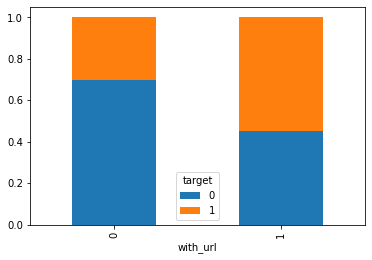

In [18]:
ct.plot(kind='bar', stacked=True)
plt.show()
# Marginally, tweets with url have higher chance to be related to disaster.

In [19]:
data['with_shorten_url'] = data['text'].apply(lambda x: 1 if re.search('http[s]*://t.co', x) else 0)
data[['with_url', 'with_shorten_url']].value_counts()

with_url  with_shorten_url
1         1                   3970
0         0                   3642
1         0                      1
dtype: int64

In [20]:
data[(data['with_url'] == 1) &\
     (data['with_shorten_url'] == 0)]['text'].values
# The last token and the url are not separated by the white space and the url is not shortten

array(['Dozens Die As two Trains Derail Into A River In Indiahttp://www.informationng.com/?p=309943'],
      dtype=object)

In [21]:
def text_preprocessing(text):
    text = re.sub(r'http\S+', '', text)
    text = TweetTokenizer(strip_handles = True, reduce_len = True).tokenize(text)
    text = [t for t in text if t not in string.punctuation]
    text = [t.lower() for t in text if t.lower() not in stopwords.words('english')]
    stemmer = PorterStemmer()
    text = [stemmer.stem(t) if '#' not in t else t for t in text]
    return text

# strip_handles: remove @user
# reduce_len: remove repeated pattern
# https://berkeley-stat159-f17.github.io/stat159-f17/lectures/11-strings/11-nltk..html

In [22]:
text_sample = data['text'].sample(1).values[0]

print(text_sample)
text_preprocessing(text_sample)

Do you have a plan? Emergency Preparedness for #Families of
Children with Special Needs  http://t.co/RdOVqaUAx5  #autism #specialneeds


['plan',
 'emerg',
 'prepared',
 '#families',
 'children',
 'special',
 'need',
 '#autism',
 '#specialneeds']

In [23]:
data['token'] = data['text'].apply(text_preprocessing)

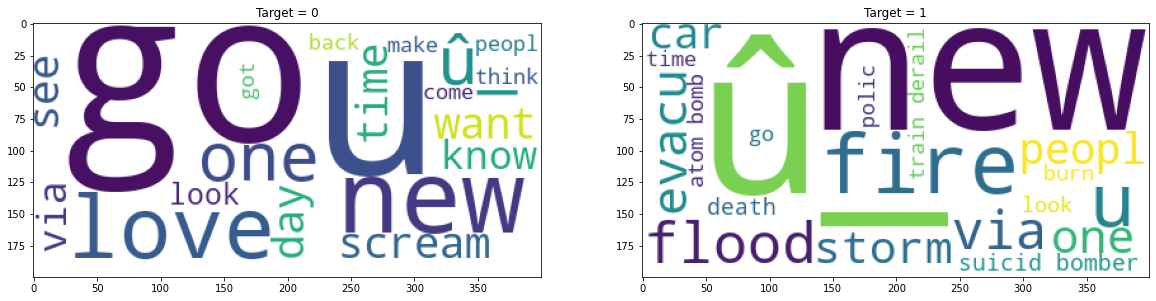

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
for i, ax in enumerate(axes):
    wc = WordCloud(max_words = 20, background_color="white").generate(' '.join(data[data['target'] == i]['token'].apply(lambda x: ' '.join(x)).tolist()))
    ax.set_title(f'Target = {i}')
    ax.imshow(wc)
    
# Some most frequent tokens are noise

In [25]:
data['target'].value_counts()
# A bit unbalanced

0    4342
1    3271
Name: target, dtype: int64

# Data Preprocessing

In [26]:
train, test = train_test_split(data, test_size = 0.3, random_state = 0)
train.shape, test.shape

((5329, 8), (2284, 8))

In [27]:
train_rescale = train.copy()

In [28]:
def keyword_preprocessing(keyword):
    if pd.isnull(keyword):
        return "Not mentioned"
    else:
        keyword = keyword.replace('%20', ' ')
        lemmatizer = WordNetLemmatizer()
        keywords = keyword.split(' ')
        keywords = [k.lower() for k in keywords]
        keywords = [lemmatizer.lemmatize(k, pos = "v") for k in keywords]
        keyword = ' '.join(keywords)
        return keyword

In [29]:
train_rescale['keyword2'] = train_rescale['keyword2'].apply(keyword_preprocessing)

In [30]:
train_rescale['keyword2'].value_counts()

flood                  77
body bag               73
bomb                   71
drown                  71
scream                 71
                       ..
avalanche              14
radiation emergency     9
epicentre               8
inundation              5
threat                  5
Name: keyword2, Length: 185, dtype: int64

In [31]:
train_rescale['location2'] = 1 - train_rescale['location'].isna()
train_rescale.head()

,keyword,location,text,target,keyword2,with_url,with_shorten_url,token,location2
id,,,,,,,,,
686,attack,#UNITE THE BLUE,@blazerfan not everyone can see ignoranceshe i...,0,attack,0,0,"[everyon, see, ignorancesh, latinoand, ever, b...",1
6913,mass%20murderer,NaN,White people I know you worry tirelessly about...,1,mass murderer,0,0,"[white, peopl, know, worri, tirelessli, black,...",0
6066,heat%20wave,NaN,Chilli heat wave Doritos never fail!,0,heat wave,0,0,"[chilli, heat, wave, dorito, never, fail]",0
1441,body%20bagging,New Your,@BroseidonRex @dapurplesharpie I skimmed throu...,0,body bag,0,0,"[skim, twitter, miss, bodi, bag]",1
6365,hostages,cuba,#hot C-130 specially modified to land in a st...,1,hostages,1,1,"[#hot, c, 130, special, modifi, land, stadium,...",1


In [32]:
train_rescale['location2'].value_counts()

1    3556
0    1773
Name: location2, dtype: int64

C:\Users\abddd\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


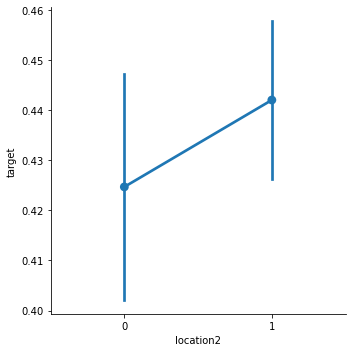

In [33]:
sns.factorplot(data = train_rescale, x = 'location2', y = 'target')
plt.show()

C:\Users\abddd\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


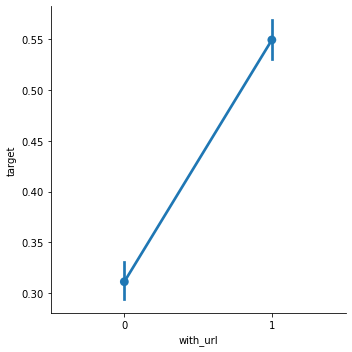

In [34]:
sns.factorplot(data = train_rescale, x = 'with_url', y = 'target')
plt.show()

In [35]:
print(f"p-value is {chi2_contingency(pd.crosstab(train_rescale['location2'], train_rescale['target']), correction=False)[1]}")
# Independent

p-value is 0.2284114967263248


In [36]:
print(f"p-value is {chi2_contingency(pd.crosstab(train_rescale['with_url'], train_rescale['target']), correction=False)[1]}")
# Not independent

p-value is 1.0587263675724737e-68


In [37]:
print(f"p-value is {chi2_contingency(pd.crosstab(train_rescale['keyword2'], train_rescale['target']), correction=False)[1]}")
# Not independent

p-value is 1.722853802175133e-215


# Naive Bayes Classifier

## Combined Model

- We assume that keyword, tokens and whether there is an url in a tweet are conditionally indepedent to each other given the class of the tweet, so as to apply Naive Bayes Classifier.
- We further assume that keyword follows categorical distribution and the word vectors follow multinomial distribution. Therefore, we decide to combine two naive bayes classifiers as the two features are under different distribution.

In [38]:
X = train[['keyword', 'text']]
y = train['target']

In [39]:
X.head()

,keyword,text
id,,
686,attack,@blazerfan not everyone can see ignoranceshe i...
6913,mass%20murderer,White people I know you worry tirelessly about...
6066,heat%20wave,Chilli heat wave Doritos never fail!
1441,body%20bagging,@BroseidonRex @dapurplesharpie I skimmed throu...
6365,hostages,#hot C-130 specially modified to land in a st...


In [40]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, x, y = None):
        return self

    def transform(self, df):
        if self.col == 'keyword':
            return df[self.col].apply(keyword_preprocessing).values.reshape(-1, 1)
        elif self.col == 'with_url':
            return df['text'].apply(lambda x: 1 if 'http' in x else 0).values.reshape(-1, 1)
        else:
            return df[self.col]

In [41]:
# Add 1 more option to filter the top k tokens

class BagOfWordVectorier(CountVectorizer):
    def __init__(self, *, input="content", encoding="utf-8", decode_error="strict", strip_accents=None,
                 lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
                 ngram_range=(1, 1), analyzer="word", max_df=1.0, min_df=1, max_features=None, vocabulary=None, 
                 binary=False, dtype=np.int64, topk = 50):
        super().__init__(input = input, encoding = encoding, decode_error = decode_error, strip_accents = strip_accents,
                         lowercase = lowercase, preprocessor = preprocessor, tokenizer = tokenizer, stop_words = stop_words, token_pattern = token_pattern,
                         ngram_range = ngram_range, analyzer = analyzer, max_df = max_df, min_df = min_df, max_features = max_features, vocabulary = vocabulary, 
                         binary = binary, dtype = dtype)
        self.topk = topk
    
    def fit_transform(self, raw_documents, y = None):
        X = super().fit_transform(raw_documents, y)
        if self.topk != 0:
            df = pd.DataFrame({'Token': self.get_feature_names_out(),
                               'Frequency': X.toarray().sum(axis = 0)})
            vocab = df.sort_values('Frequency', ascending = False)['Token'].iloc[self.topk: ].tolist()
            vocab_dict = dict([(u, v) for v, u in enumerate(vocab)])
            self.vocabulary = vocab_dict
            X = super().fit_transform(raw_documents, y)
        return X

In [42]:
class CategoricalNBTransformer(CategoricalNB):
    def transform(self, X):
        return self.predict_proba(X)

In [43]:
class MultinomialNBTransformer(MultinomialNB):
    def transform(self, X):
        return self.predict_proba(X)

In [44]:
class NaiveBayesClassifier(ClassifierMixin): 
    def fit(self, X, y):
        self.n_classes = y.nunique()
        self.classes_ = y.unique()
        return self
    
    def predict(self, X):
        return np.array([self.classes_[np.argmax(x)] for x in self.predict_proba(X)])
    
    def predict_proba(self, X):
        for i in range(1, int(X.shape[1]/2)+1):
            if i == 1:
                product = X[:, ((i-1)*self.n_classes):(i*self.n_classes)]
            else:
                product *= X[:, ((i-1)*self.n_classes):(i*self.n_classes)]   
        
#         product = X[:, :self.n_classes] * X[:, self.n_classes: ]
        return product / product.sum(axis = 1).reshape(-1, 1)

In [45]:
model = Pipeline([('mixed', FeatureUnion([('categorical', Pipeline([('keyword', ItemSelector('keyword')),
                                                                    ('ordinal_transformer', OrdinalEncoder()),
                                                                    ('categoricalnb', CategoricalNBTransformer())])),
                                          ('binary', Pipeline([('with_url', ItemSelector('with_url')),
                                                               ('categoricalnb', CategoricalNBTransformer(alpha = 1e-10))])),
                                          ('multinomial', Pipeline([('text', ItemSelector('text')),
                                                                    ('bow_transformer', BagOfWordVectorier(analyzer = text_preprocessing,
                                                                                                           topk = 50)),
                                                                    ('multinomialnb', MultinomialNBTransformer())]))])),
                  ('model', NaiveBayesClassifier())])

In [46]:
model.fit(X, y)

Pipeline(steps=[('mixed',
                 FeatureUnion(transformer_list=[('categorical',
                                                 Pipeline(steps=[('keyword',
                                                                  ItemSelector(col='keyword')),
                                                                 ('ordinal_transformer',
                                                                  OrdinalEncoder()),
                                                                 ('categoricalnb',
                                                                  CategoricalNBTransformer())])),
                                                ('binary',
                                                 Pipeline(steps=[('with_url',
                                                                  ItemSelector(col='with_url')),
                                                                 ('categoricalnb',
                                                                 

In [47]:
prob = model.predict_proba(X)[:, 1]

0.9531935197514426

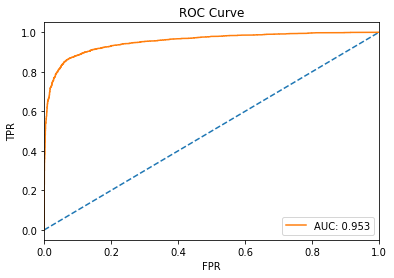

In [48]:
plot_roc(y, prob)

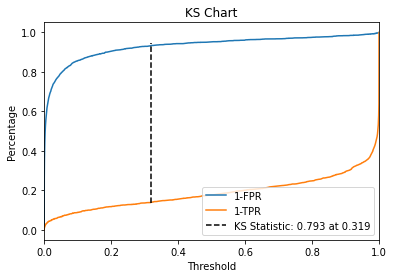

In [49]:
_, threshold = plot_ks(y, prob)

In [50]:
accuracy_score(y, [1 if p >= threshold else 0 for p in prob])

0.9012948020266467

In [51]:
confusion_matrix(y, prob, threshold)

Predicted,0,1,Predictive Value
Actual,,,
0,2803.0000,201.000000,0.933089
1,325.0000,2000.000000,0.860215
Specificity & Sensitivity,0.8961,0.908678,0.901295


In [52]:
cross_val_score(model, X, y, scoring = 'roc_auc', cv=5)
# Overfitting

array([0.84237203, 0.85453098, 0.85686222, 0.84877176, 0.82866308])

In [53]:
def text_preprocessing_ngram(text):
    text = text_preprocessing(text)
    text2 = [' '.join([text[i], text[i+1]]) for i in range(len(text) - 1)]
    text = text + text2
    return text

In [54]:
params = {'mixed__categorical__categoricalnb__min_categories': [10, 20, 30, None],
          'mixed__multinomial__bow_transformer__max_features': [1000, 2000, 5000, None],
          'mixed__multinomial__bow_transformer__analyzer': [text_preprocessing, text_preprocessing_ngram],
          'mixed__multinomial__bow_transformer__topk': [0, 50, 100]}
grid = GridSearchCV(model, param_grid = params, cv = 5, scoring = 'roc_auc').fit(X, y)

In [55]:
grid.best_params_

{'mixed__categorical__categoricalnb__min_categories': 10,
 'mixed__multinomial__bow_transformer__analyzer': <function __main__.text_preprocessing(text)>,
 'mixed__multinomial__bow_transformer__max_features': 5000,
 'mixed__multinomial__bow_transformer__topk': 0}

In [56]:
grid.best_score_

0.8523628689340944

## with_url and Text

In [52]:
model_1 = Pipeline([('mixed', FeatureUnion([('binary', Pipeline([('with_url', ItemSelector('with_url')),
                                                                 ('categoricalnb', CategoricalNBTransformer(alpha = 1e-10))])),
                                            ('multinomial', Pipeline([('text', ItemSelector('text')),
                                                                      ('bow_transformer', BagOfWordVectorier(analyzer = text_preprocessing,
                                                                                                             max_features = 5000,
                                                                                                             topk = 0)),
                                                                      ('multinomialnb', MultinomialNBTransformer())]))])),
                    ('model', NaiveBayesClassifier())])

In [53]:
model_1.fit(X, y)

Pipeline(steps=[('mixed',
                 FeatureUnion(transformer_list=[('binary',
                                                 Pipeline(steps=[('with_url',
                                                                  ItemSelector(col='with_url')),
                                                                 ('categoricalnb',
                                                                  CategoricalNBTransformer(alpha=1e-10))])),
                                                ('multinomial',
                                                 Pipeline(steps=[('text',
                                                                  ItemSelector(col='text')),
                                                                 ('bow_transformer',
                                                                  BagOfWordVectorier(analyzer=<function text_preprocessing at 0x000001D6F92E0D30>,
                                                                                     

In [54]:
np.mean(cross_val_score(model_1, X, y, scoring = 'roc_auc', cv=5))
# The model performance does not drop too much when not including keyword, it would be better to exclude the keyword, 
# as it is not mentioned how keyword is extracted.

0.843340223880152

# Model Evaluation

In [55]:
model = model_1

## Train

In [56]:
prob = model.predict_proba(X)[:, 1]

0.9278705811606031

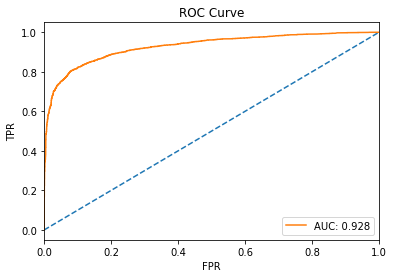

In [57]:
plot_roc(y, prob)

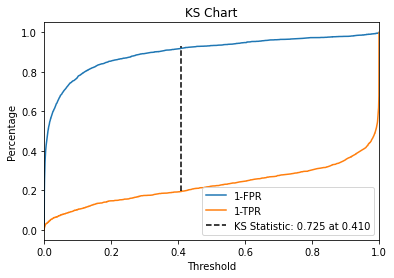

In [58]:
_, threshold = plot_ks(y, prob)

In [59]:
accuracy_score(y, [1 if p >= threshold else 0 for p in prob])

0.8695815349971853

In [60]:
confusion_matrix(y, prob, threshold)

Predicted,0,1,Predictive Value
Actual,,,
0,2761.000000,243.000000,0.919108
1,452.000000,1873.000000,0.805591
Specificity & Sensitivity,0.859322,0.885161,0.869582


## Test

In [61]:
test_X = test[['keyword', 'text']]
test_y = test['target']

In [62]:
test_prob = model.predict_proba(test_X)[:, 1]

0.8549833774179378

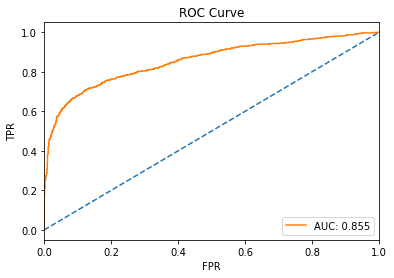

In [63]:
plot_roc(test_y, test_prob)

(0.5849268574787398, 0.5054757820852382)

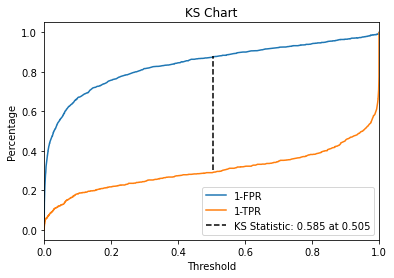

In [64]:
plot_ks(test_y, test_prob)

In [65]:
accuracy_score(test_y, [1 if p >= threshold else 0 for p in test_prob])

0.7972854640980735

In [66]:
confusion_matrix(test_y, test_prob, threshold)

Predicted,0,1,Predictive Value
Actual,,,
0,1137.000000,201.000000,0.849776
1,262.000000,684.000000,0.723044
Specificity & Sensitivity,0.812723,0.772881,0.797285


# Final Model

In [67]:
X = data[['keyword', 'text']]
y = data['target']

In [68]:
model.fit(X, y)

Pipeline(steps=[('mixed',
                 FeatureUnion(transformer_list=[('binary',
                                                 Pipeline(steps=[('with_url',
                                                                  ItemSelector(col='with_url')),
                                                                 ('categoricalnb',
                                                                  CategoricalNBTransformer(alpha=1e-10))])),
                                                ('multinomial',
                                                 Pipeline(steps=[('text',
                                                                  ItemSelector(col='text')),
                                                                 ('bow_transformer',
                                                                  BagOfWordVectorier(analyzer=<function text_preprocessing at 0x000001D6F92E0D30>,
                                                                                     

In [69]:
prob = model.predict_proba(X)[:, 1]

0.9179188480034969

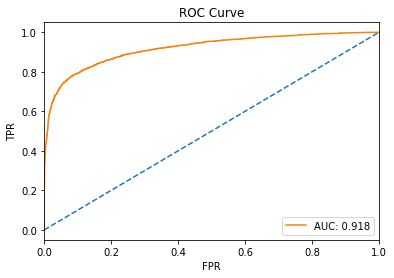

In [70]:
plot_roc(y, prob)

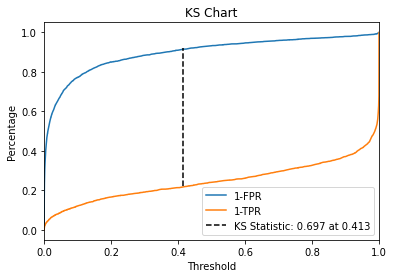

In [71]:
_, threshold = plot_ks(y, prob)

In [72]:
accuracy_score(y, [1 if p >= threshold else 0 for p in prob])

0.8577433337711808

In [73]:
confusion_matrix(y, prob, threshold)

Predicted,0,1,Predictive Value
Actual,,,
0,3968.000000,374.000000,0.913865
1,709.000000,2562.000000,0.783247
Specificity & Sensitivity,0.848407,0.872616,0.857743


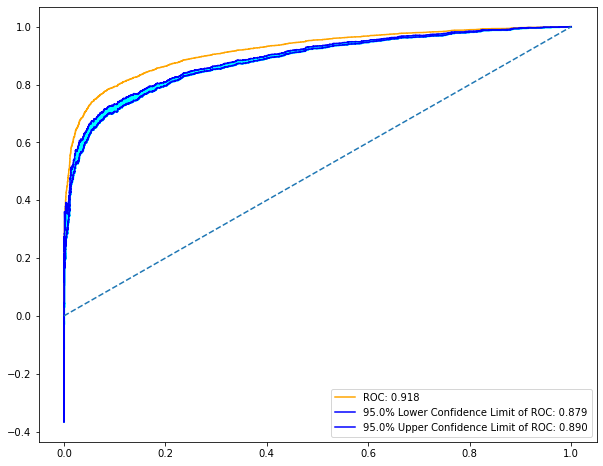

In [74]:
plt.figure(figsize = (10,8))
EmpiricalBootstrappingROC(data, X.columns, y.name, model, typ = 'basic', B = 20)
# Despite the overfitting problem, the variance of AUC is small.

In [75]:
data['prob'] = prob
data['pred'] = [1 if p >= threshold else 0 for p in prob]

In [76]:
# sample = data[(data['target'] == 0) &\
#               (data['pred'] == 1)].sample(1)
sample = data[(data['target'] != data['pred'])].sample(5)
sample

,keyword,location,text,target,keyword2,with_url,with_shorten_url,token,prob,pred
id,,,,,,,,,,
9445,terrorism,NaN,Truth...\r\nhttps://t.co/h6amECX5K7\r\n#News\r...,0,terrorism,1,1,"[truth, ..., #news, #bbc, #cnn, #islam, #truth...",0.996547,1
7415,obliterated,Reading MA,Drunk Meals 101: What To Cook When You're Tota...,1,obliterated,1,1,"[drunk, meal, 101, cook, total, obliter]",0.008249,0
354,annihilation,Spain,:StarMade: :Stardate 3: :Planetary Annihilatio...,1,annihilation,1,1,"[starmad, stardat, 3, :p, lanetari, annihil, :...",0.168973,0
3318,demolished,NaN,Got my first gamer troll I just demolished a k...,1,demolished,0,0,"[got, first, gamer, troll, demolish, kid, phil...",0.027922,0
2307,collapse,Scotland,Would a paramedic really do that? Leave someon...,1,collapse,0,0,"[would, paramed, realli, leav, someon, insid, ...",0.112993,0


In [77]:
sample['text'].values

array(['Truth...\r\nhttps://t.co/h6amECX5K7\r\n#News\r\n#BBC\r\n#CNN\r\n#Islam\r\n#Truth\r\n#god\r\n#ISIS\r\n#terrorism\r\n#Quran\r\n#Lies http://t.co/B8iWRdxcm0',
       "Drunk Meals 101: What To Cook When You're Totally Obliterated http://t.co/m19iVWrdkk",
       ':StarMade: :Stardate 3: :Planetary Annihilation:: http://t.co/I2hHvIUmTm via @YouTube',
       'Got my first gamer troll I just demolished a kid from Philly with Toronto on MLB and he was upset #BacktoBack #ChargedUp ??????',
       "Would a paramedic really do that? Leave someone inside a building that's about to collapse/blow up? @HalloIkBenWill"],
      dtype=object)

In [78]:
sample['token'].values

array([list(['truth', '...', '#news', '#bbc', '#cnn', '#islam', '#truth', '#god', '#isis', '#terrorism', '#quran', '#lies']),
       list(['drunk', 'meal', '101', 'cook', 'total', 'obliter']),
       list(['starmad', 'stardat', '3', ':p', 'lanetari', 'annihil', '::', 'via']),
       list(['got', 'first', 'gamer', 'troll', 'demolish', 'kid', 'philli', 'toronto', 'mlb', 'upset', '#backtoback', '#chargedup']),
       list(['would', 'paramed', 'realli', 'leav', 'someon', 'insid', 'build', "that'", 'collaps', 'blow'])],
      dtype=object)

# Prediction

In [79]:
predict = pd.read_csv('../../data/Disaster/test.csv', index_col = 0)
predict.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [80]:
sample = pd.DataFrame(index = predict.index)
sample['target'] = [1 if p >= threshold else 0 for p in model.predict_proba(predict)[:, 1]]
sample.head()

,target
id,
0,1
2,0
3,1
9,0
11,1


In [81]:
sample.to_csv('../../data/Disaster/submission.csv')

# Score in Kaggle

https://www.kaggle.com/competitions/nlp-getting-started/overview  
0.79129

# Further Work

- We excluded the keyword from modelling as its logic of extraction is unknown and there is no longer keyword tagged with a tweet while the model is applied outside the dataset. However, most of the keywords make sense and can be utilized in modellng. In the future, we can group it into more general classes and treat it as a latent variable. It can improve the preformance.
- Although Naive Bayes is simple and easy to understand, it ignores much information like the sequence of the tokens. In the future, we can try using recurrent neural network (RNN) which the previous token can make an effect on the prediction by the current token.
- Moreover, Bag of Word is an easy tokenization algorithm. It has many drawbacks like not penalizing some frequent tokens but with less information, like a, an, the, and it awards the tokens with high term frequencies. Also, n-gram groups every neigbour tokens together but most of them are not the phasal word. We can use some pretrained tokenizer like BERT for a better tokenization and vectorization.